# Navigable network
 In this project I will try to reproduce the research about finding a route or path between twitter users, useing decentralized algorithm.

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import powerlaw as pw
import networkx as nx
import collections as col

from tqdm import trange

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.gridspec as gridspec

from IPython.display import display

# import dask.dataframe as dd

In [2]:
path_data = './data/'
path_pic = './output/'

### Just some matplotlib and seaborn parameter tuning

In [3]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 20
axistextsize = 20
axiscbarfontsize = 15

# Scatter plot only parameters
sc = 8
alpha = 0.7

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

## 1. Preprocessed files

* ...**sub files**, I selected a *smaller area* of the United States every node is part of this area. And because the navigability feature has no meaning in not fully connected networks, we work with the edgelist, nodelist and neighborlist of the **giant component**(GC) of the network.<br><br>

* ...**latlon file** contains every node's ID, with the latitude and longitude coordinates of the node with the transformed **x-y coordinates from lat-lon** (point column) So the euclidean distance works. $d = \sqrt{(\vec{x}-\vec{y})^2}$(https://epsg.io/26917)<br><br>
* ...**elist** big networks usually stored as edgelists, each row is an **edge of the network**, edge between a source and a target node. Our network is undirected so the direction or the order of source target nodes doesn't matter.<br><br>

* ...**neigh** : Created the **neighborlist of the network**, every node has neighbors (at least 1), those are stored in a **list**, the length of this list is the **degree**, and I added the **local clustering coefficient** of each node to the neighborlist.<br><br>


In [4]:
# I like long variable names. Sorry.
df_neigh_list_sub_GC_nodes = pd.read_excel(path_data+'neighbor_list_small_network_GC.xlsx') 
df_neigh_list_sub_GC_nodes['neighbors'] = df_neigh_list_sub_GC_nodes.neighbors.apply(lambda x: x[1:-1].split(','))
df_neigh_list_sub_GC_nodes['neighbors'] = df_neigh_list_sub_GC_nodes.neighbors.apply(lambda x: [int(xx) for xx in x])

df_latlon_sub_GC_nodes = pd.read_excel(path_data+'latlon_points_small_network_GC.xlsx')
df_latlon_sub_GC_nodes['point'] = df_latlon_sub_GC_nodes['point'].apply(lambda x: eval(x))

df_elist_sub_GC = pd.read_excel(path_data+'edgelist_small_network_GC.xlsx')

#### 1./a. Inspect `df_neigh_list_sub_GC_nodes`

In [5]:
display(df_neigh_list_sub_GC_nodes.head())
display(df_neigh_list_sub_GC_nodes.tail())

,source,neighbors,degree,clus_coeff
0,456,"[12797, 817977, 3594701, 8517152, 8957182, 115...",13,0.435897
1,2900,"[2922, 12797, 817977, 1584901, 2596061, 544942...",32,0.403226
2,2922,"[2900, 817977, 864371, 1584901, 2596061, 54494...",57,0.200501
3,4517,"[7807642, 11702862]",2,0.000000
4,11713,"[718703, 5563672, 16610697]",3,0.000000


,source,neighbors,degree,clus_coeff
39496,1002919273,[521064783],1,0.000000
39497,1002954938,[510488536],1,0.000000
39498,1002990643,[298912592],1,0.000000
39499,1003024616,"[106154186, 302881377, 354470164, 364000259, 4...",11,0.327273
39500,1003095236,[582335484],1,0.000000


#### 1./b. Inspect `df_latlon_sub_GC_nodes`

In [6]:
display(df_latlon_sub_GC_nodes.head())
display(df_latlon_sub_GC_nodes.tail())

,user_id,lat,lon,point
0,456,38.660509,-90.313328,"(-311078.14051495853, 4320488.224860743)"
1,2900,38.948643,-94.734254,"(-692471.2742051638, 4401891.07985477)"
2,2922,39.082087,-94.596434,"(-678192.8443919134, 4414946.199469008)"
3,4517,38.609344,-90.334675,"(-313525.1031373816, 4314985.363990909)"
4,11713,37.151459,-93.290822,"(-593663.0619047317, 4183145.1173783466)"


,user_id,lat,lon,point
39496,1002919273,36.921541,-89.353892,"(-244794.6275448416, 4118919.216052284)"
39497,1002954938,36.061009,-94.164905,"(-688787.2241927071, 4071941.98560365)"
39498,1002990643,38.937658,-92.320815,"(-482475.7861862726, 4371304.66724682)"
39499,1003024616,39.039990,-94.233903,"(-647364.2310464168, 4405509.119086106)"
39500,1003095236,36.933940,-94.868320,"(-738325.9246197192, 4178621.0436445805)"


#### 1./c. Inspect `df_elist_sub_GC`

In [7]:
display(df_elist_sub_GC.head())
display(df_elist_sub_GC.tail())

,source,target
0,12797,456
1,12797,2900
2,12797,864371
3,12797,2704561
4,12797,3594701


,source,target
193294,900366265,595977550
193295,738921578,619547211
193296,846759871,765150145
193297,746077662,741250296
193298,747877129,899010212


## 2. A few networkscience features
* size of network's GC
* degree distribution
* complementary cumulative degree distribution 
* degree distribution's exponent with powerlaw (https://pypi.org/project/powerlaw/ and https://nbviewer.jupyter.org/gist/anonymous/bb4e1dfafd9e90d5bc3d with examples)
* average clustering coefficient

In [8]:
def nr_of_nodes_from_elist(df_elist):
    """
    Returns the number of nodes
    """
    return (df_elist['source'].append(df_elist['target'])).nunique()

def nr_of_edges_from_elist(df_elist):
    """
    Returns the number of edges in an edgelist.
    """
    return len(df_elist)

def nr_of_edges_from_elist_parallel(df_elist):
    """
    Every edge is parallel in `df_elist`.
    """
    return len(df_elist)//2

def make_neigh_list(df_elist):
    neighs_of_source = dict(df_elist.groupby(by='source')['target'].apply(list))
    
    df_neigh = pd.DataFrame({'source':list(neighs_of_source.keys()),
                             'neighbors':list(neighs_of_source.values())})
    df_neigh['degree'] = df_neigh['neighbors'].apply(len)
    return df_neigh

def degdist_from_network(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = col.Counter(degree_sequence)
    return dict(degreeCount.items())

def component_sizedist_from_network(G):
    connected_components = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    conn_count = col.Counter(connected_components)
    return dict(conn_count.items())

def degdist_from_neigh_list(df_neigh):
    degree_sequence = sorted(list(df_neigh['degree']))
    degreeCount = col.Counter(degree_sequence)
    degreeCount = {k:(v/len(df_neigh)) for k,v in degreeCount.items()}
    return dict(degreeCount.items())

def cum_degdist_complementer_from_neigh_list(df_neigh):
    degdist = degdist_from_neigh_list(df_neigh)
    degdist = col.OrderedDict(sorted(degdist.items()))

    k_vals = list(degdist.keys())
    p_probs = list(degdist.values())

    cum_probs = {}
    for i, k in enumerate(k_vals):
        sub_list = [x for x in p_probs[:i+1]]
        cum_probs[k] = 1 - sum(sub_list)

    return cum_probs

def clustering_coeff_neigh_list(df_neigh,node_name):
    
    neighbors = df_neigh[df_neigh['source']==node_name]['neighbors'].iloc[0]
    k = len(neighbors)
    if k == 1:
        return 0.0
    
    links = 0.0
    
    sub_neighs = [set(x) for x in list(df_neigh[df_neigh.source.isin(neighbors)]['neighbors'])]
    neighbors = set(neighbors)
    for i in range(len(sub_neighs)):
        
        links += len(sub_neighs[i].intersection(neighbors))
    
    return links/(k*(k-1))

In [9]:
print('Nr. of nodes: ', nr_of_nodes_from_elist(df_elist_sub_GC))
print('Nr. of edges: ', nr_of_edges_from_elist(df_elist_sub_GC))

Nr. of nodes:  39501
Nr. of edges:  193299


In [10]:
# Calculate degree distribution
deg_dist_sub = degdist_from_neigh_list(df_neigh_list_sub_GC_nodes)
X = list(deg_dist_sub.keys())
y = list(deg_dist_sub.values())

# Calculate cumulative degree distribution
cum_deg_dist_sub = cum_degdist_complementer_from_neigh_list(df_neigh_list_sub_GC_nodes)
X_c = list(cum_deg_dist_sub.keys())[:-1]
y_c = list(cum_deg_dist_sub.values())[:-1]

In [11]:
# Fit power law on the data
deg_dist_sub_squence = list(df_neigh_list_sub_GC_nodes.degree)
fit_deg = pw.Fit(deg_dist_sub_squence,discrete=True, xmin=20, xmax=100)

/home/masterdesky/miniconda3/envs/dsclab/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/masterdesky/miniconda3/envs/dsclab/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [12]:
fit_deg.sigma

0.02254933410572992

In [13]:
print('Exponent of degree distribution: {0:.3f} +/- {1:.3f}'.format(fit_deg.alpha, fit_deg.sigma))

Exponent of degree distribution: 2.604 +/- 0.023


In [14]:
clust_coef_avg = np.average(df_neigh_list_sub_GC_nodes.clus_coeff)
print('Avg. clustering coefficient: {0:.3f}'.format(clust_coef_avg))

Avg. clustering coefficient: 0.172


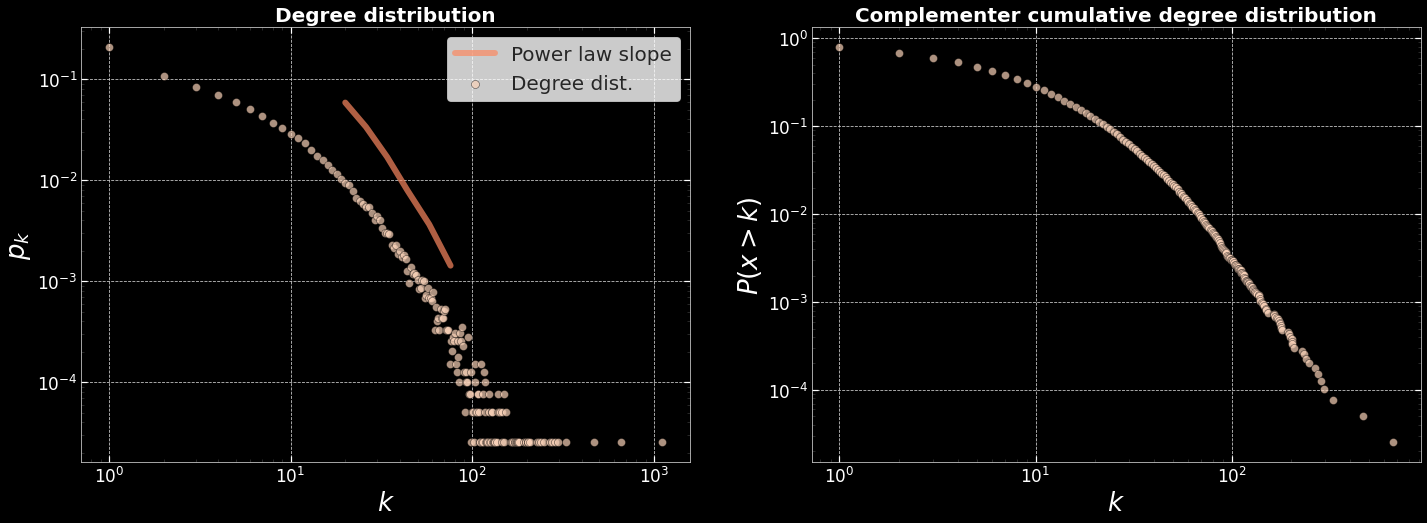

In [15]:
# Plot edge degree distribution and cumulative degree distribution
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*8),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

# AXES 1. : DEGREE DIST.
ax = axes[0]
ax.scatter(X, y, label='Degree dist.',
           color=rocket_cmap(0.93), ec='black', lw=0.5,
           s=sc**2, alpha=alpha)
ax.plot(fit_deg.pdf()[0][:-1], fit_deg.pdf()[1], label='Power law slope',
        color=cm.magma(0.75), lw=6, ls='-', alpha=0.7)

# AXES 2. : CUMULATIVE DEGREE DIST.
ax = axes[1]
ax.scatter(X_c, y_c,
           color=rocket_cmap(0.93), ec='black', lw=0.5,
           s=sc**2, alpha=alpha)

titles = [
    'Degree distribution',
    'Complementer cumulative degree distribution',
]
ylabels = [
    '$p_k$',
    '$P(x > k)$'
]
for i, ax in enumerate(axes.reshape(-1)):
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_title(titles[i],
                 fontsize=axistitlesize, fontweight='bold', color='w')
    ax.set_xlabel('$k$', fontsize=axislabelsize, fontweight='bold', color='w')
    ax.set_ylabel(ylabels[i], fontsize=axislabelsize, fontweight='bold', color='w')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='w')
    
    if i == 0:
        ax.legend(loc='upper right', fontsize=axislegendsize)

plt.savefig(path_pic + 'degdist_small.png',
            dpi=200,
            bbox_inches='tight')

plt.show()

# Distance distribution between every pairs

* Let's estimate the distance between a handful of users
* Let's calculate the distances between 5000 randomly choosen points.

In [10]:
from scipy.stats import gaussian_kde

In [11]:
N = len(df_neigh_list_sub_GC_nodes)
space = (((N**2 - 1)/2) * 8) / (1024**3)
print('It\' difficult to calculate the distance between every node. It would require {0:.3f} Gb memory'.format(space))

It' difficult to calculate the distance between every node. It would require 5.813 Gb memory


In [12]:
%%time
N_sample = 12000
points_coords = np.array([np.array([x[0],x[1]]) for x in df_latlon_sub_GC_nodes.sample(N_sample).point])
distances_betw_points = scipy.spatial.distance.cdist(points_coords, points_coords)

distances_betw_points = distances_betw_points[distances_betw_points != 0.0]
distances_betw_points = distances_betw_points.flatten() / 1000

CPU times: user 914 ms, sys: 277 ms, total: 1.19 s
Wall time: 1.2 s


In [19]:
%%time
samp_size = 100
# Create histogram
hist, bins = np.histogram(distances_betw_points, bins=samp_size, density=True)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.36 s


In [25]:
%%time
# Create density plot
density = gaussian_kde(distances_betw_points)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
xs = np.linspace(0, int(distances_betw_points.max()) + 1, samp_size)
ys = density(xs)

CPU times: user 2min 20s, sys: 1.66 s, total: 2min 22s
Wall time: 2min 21s


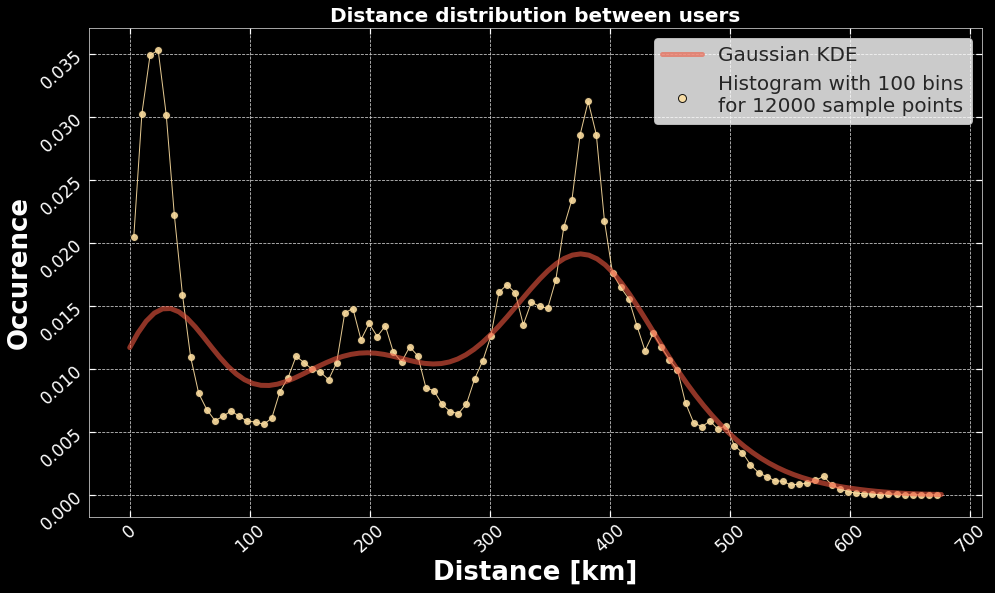

In [31]:
fig, axes = plt.subplots(figsize=(16,9),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

sc = 8
label = ('Histogram with {} bins\n'.format(samp_size) +
         'for {} sample points'.format(N_sample))
axes.scatter(center, hist / hist.sum(), label=label,
             color=cm.magma(0.93), ec='black', alpha=0.9, s=sc**2)
axes.plot(center, hist / hist.sum(),
          color=cm.magma(0.93), lw=1, alpha=0.9)
#axes.bar(center, (hist / hist.sum()), width=width, label=label,
#         color=cm.magma(0.93), ec='black', alpha=0.9)
axes.plot(xs, (ys / hist.sum()), label='Gaussian KDE',
          color=rocket_cmap(0.65), lw=5, ls='-', alpha=0.6)

axes.set_xlabel('Distance [km]', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('Occurence', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_title('Distance distribution between users', fontsize=axistitlesize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, labelrotation=42, colors='white')

axes.legend(loc='upper right', fontsize=axislegendsize)

plt.savefig(path_pic + 'distance_dist_of_{0}_points_w_kde.png'.format(N_sample),
            dpi = 200,
            bbox_inches='tight')

plt.show()

# Conclusion:

* The sample is too big to run it myself, and the randomly choosen set doesn't follow a powerlaw.
* It's already a subset of the subset of the data. I don't expect similar results. The algorithms are similar to the original research.

## 4. Greedy algorithm

In [9]:
def get_distance(t1, t2):
    """
    Returns distance in meters.
    """
    return np.linalg.norm(np.array(t1) - np.array(t2))

def get_distance_from_node_names(n1,n2,df_latlon):
    t1 = df_latlon[df_latlon.user_id == n1].point.iloc[0]
    t2 = df_latlon[df_latlon.user_id == n2].point.iloc[0]
    return get_distance(t1,t2)

def get_closest_neigh_to_target_node(neighbors,target_node,df_latlon):
    target_coord = df_latlon[df_latlon.user_id == target_node].point.iloc[0]
    
    coordinates = [df_latlon[df_latlon.user_id == n].point.iloc[0] for n in neighbors]
    distances = [get_distance(t,target_coord) for t in coordinates]
    return neighbors[distances.index(min(distances))]

def get_closest_neigh_to_target_node_no_reps(neighbors,target_node,df_latlon,path_nodes):
    target_coord = df_latlon[df_latlon.user_id == target_node].point.iloc[0]
    
    coordinates = [df_latlon[df_latlon.user_id == n].point.iloc[0] for n in neighbors]
    distances = [get_distance(t,target_coord) for t in coordinates]
    distances = [x for x in distances if x not in path_nodes]
    
    return neighbors[distances.index(min(distances))]

def get_greedy_path_with_dist(start_node, target_node, df_neigh, df_latlon,
                              max_steps=30, dist_threshold=1000):
    
    # Distance threshold [meters]
    D_THRES = dist_threshold if dist_threshold is not None else np.finfo(np.float64).max
    
    # If the start node and the end node are the same there's
    # nothing to do, return with an empty path list
    if start_node == target_node: return []
    
    # List of nodes visited during the pathing between
    # node A (start node) and node B (target node)
    path_of_nodes = []
    
    # Initial 0th state of the Greedy algorithm
    nr_step = 0
    current_node = start_node
    path_of_nodes.append(start_node)
    
    # Stepping with the Greedy algorithm
    while nr_step < max_steps and current_node != target_node:
        nr_step +=1 
        
        # Get the list of the nearest neighbors
        neighbors_of_curr = df_neigh[df_neigh.source == current_node].neighbors.iloc[0]
        # Exclude the already visited nodes from the selected nearest neighbours
        # to prevent infinite loops
        neighbors_of_curr = list(set(neighbors_of_curr) - (set(path_of_nodes)))
        
        # If there are no nodes left, stop and return
        # with the so far accumulated node list
        if neighbors_of_curr == []: return path_of_nodes
        
        # Select the nearest node and step on that
        current_node = get_closest_neigh_to_target_node(neighbors_of_curr, target_node, df_latlon)
        # Add this new node to the path list
        path_of_nodes.append(current_node)
        
        # Break loop, if we are close to the target (distance < D_THRES)
        dist_start_curr = get_distance_from_node_names(start_node, current_node, df_latlon)
        if dist_start_curr < D_THRES:
            nr_step = max_steps
    
    return path_of_nodes

## 4. Initialization

In [26]:
nr_pairs = 2000
max_hop = 50
selected_nodes = np.random.choice(df_neigh_list_sub_GC_nodes.source.values, 2*nr_pairs)
starting_points = selected_nodes[:nr_pairs]
target_points = selected_nodes[nr_pairs:]

In [27]:
def paths_between_points(THRES=1000):
    """
    Collects the path list between all start and end nodes within a given
    distance threshold.
    """    
    paths_betw_points_with_dist = []
    for i in trange(nr_pairs):
        paths_betw_points_with_dist.append(get_greedy_path_with_dist(starting_points[i],
                                                                     target_points[i],
                                                                     df_neigh_list_sub_GC_nodes,
                                                                     df_latlon_sub_GC_nodes,
                                                                     max_steps=max_hop,
                                                                     dist_threshold=THRES))
    return paths_betw_points_with_dist

In [28]:
def save_path_data(starting_points, target_points, paths_betw_points_with_dist,
                   THRES=1000, nr_pairs=2000):
    
    df_greedy_results_dist = pd.DataFrame({'start':starting_points,
                                           'target':target_points,
                                           'path':paths_betw_points_with_dist})
    df_greedy_results_dist['path_length'] = \
                    df_greedy_results_dist.path.apply(lambda x: len(x))

    # Convert both to [km] by multiplying with 1/1000
    df_greedy_results_dist['distance_at_end'] = 1/1000 *\
                    df_greedy_results_dist.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                        x.path[-1],
                                                                                        df_latlon_sub_GC_nodes), axis=1)
    df_greedy_results_dist['distance_at_start'] = 1/1000 *\
                    df_greedy_results_dist.apply(lambda x: get_distance_from_node_names(x.target,
                                                                                        x.start,
                                                                                        df_latlon_sub_GC_nodes), axis=1)
    
    df_greedy_results_dist.to_excel(path_data +
                                    'greedy_results_distance_threshold_{0}m_{1}_pairs.xlsx'.format(THRES, nr_pairs),
                                    index=False)

### 4./a. : 0.1 km threshold

In [32]:
%%time
# Depends on rig, but takes ~10 minutes
# with 0.1 km distance threshold
# THRES : float in [meters]
THRES = 100
paths_betw_points_with_dist = paths_between_points(THRES=THRES)

100%|██████████| 2000/2000 [09:50<00:00,  3.39it/s]

CPU times: user 9min 50s, sys: 845 ms, total: 9min 50s
Wall time: 9min 50s


In [33]:
save_path_data(starting_points, target_points, paths_betw_points_with_dist,
               THRES=THRES, nr_pairs=nr_pairs)

### 4./b. : 1 km threshold

In [28]:
%%time
# Depends on rig, but takes ~10 minutes
# with 1 km distance threshold
# THRES : float in [meters]
THRES = 1000
paths_betw_points_with_dist = paths_between_points(THRES=THRES)

100%|██████████| 2000/2000 [09:23<00:00,  3.55it/s]

CPU times: user 9min 23s, sys: 741 ms, total: 9min 24s
Wall time: 9min 23s


In [29]:
save_path_data(starting_points, target_points, paths_betw_points_with_dist,
               THRES=THRES, nr_pairs=nr_pairs)

### 4./c. : 10 km threshold

In [30]:
%%time
# Depends on rig, but takes ~10 minutes
# with 10 km distance threshold
# THRES : float in [meters]
THRES = 10000
paths_betw_points_with_dist = paths_between_points(THRES=THRES)

100%|██████████| 2000/2000 [06:00<00:00,  5.55it/s]

CPU times: user 6min, sys: 413 ms, total: 6min 1s
Wall time: 6min


In [31]:
save_path_data(starting_points, target_points, paths_betw_points_with_dist,
               THRES=THRES, nr_pairs=nr_pairs)

# Results
* The ratio of finished path
* Visualize one or two path on the map. 
* Distribution of required hop numbers
* Distribution of the distance between the target node and the starting node
* Distribution of the distance between the target node and the last path node

In [10]:
def load_path_data(THRES=1000, nr_pairs=2000):
    
    fn = path_data + 'greedy_results_distance_threshold_{0}m_{1}_pairs.xlsx'.format(THRES, nr_pairs)
    
    df = pd.read_excel(fn)
    df['path'] = df.path.apply(lambda x: x[1:-1].split(','))
    df['path'] = df.path.apply(lambda x: [int(xx) for xx in x])

    return df

In [11]:
df_greedy_results_dist_100 = load_path_data(THRES=100, nr_pairs=2000)
df_greedy_results_dist_1000 = load_path_data(THRES=1000, nr_pairs=2000)
df_greedy_results_dist_10000 = load_path_data(THRES=10000, nr_pairs=2000)

In [12]:
df_greedy_results_dist_finished_100 = df_greedy_results_dist_100[df_greedy_results_dist_100.path_length < 51]
df_greedy_results_dist_finished_1000 = df_greedy_results_dist_1000[df_greedy_results_dist_1000.path_length < 51]
df_greedy_results_dist_finished_10000 = df_greedy_results_dist_10000[df_greedy_results_dist_10000.path_length < 51]

In [13]:
def print_success(df_all,df_finished):
    print('The success ratio: {0:.2f}%'.format(len(df_finished)/len(df_all) * 100))
    print('{0} successful routing out of {1}\n'.format(len(df_finished), len(df_all)))

In [14]:
print('With 0.1 km threshold:')
print_success(df_greedy_results_dist_100,df_greedy_results_dist_finished_100)
print('With 1 km threshold:')
print_success(df_greedy_results_dist_1000,df_greedy_results_dist_finished_1000)
print('With 10 km threshold:')
print_success(df_greedy_results_dist_10000,df_greedy_results_dist_finished_10000)

With 0.1 km threshold:
The success ratio: 84.60%
1692 successful routing out of 2000

With 1 km threshold:
The success ratio: 85.65%
1713 successful routing out of 2000

With 10 km threshold:
The success ratio: 91.40%
1828 successful routing out of 2000



### Number of steps (hops) needed to reach the target node for different distance thresholds

In [15]:
# Calculate path lengths
req_hop_nrs_100 = col.Counter(df_greedy_results_dist_finished_100.path_length)
req_hop_nrs_1000 = col.Counter(df_greedy_results_dist_finished_1000.path_length)
req_hop_nrs_10000 = col.Counter(df_greedy_results_dist_finished_10000.path_length)

In [37]:
def plot_hop_count(req_hop_nrs, color=cm.magma(0.93),
                   THRES=1000, nr_pairs=2000):
    
    # Plot barplot of hop counts
    fig, axes = plt.subplots(figsize=(16,9),
                             facecolor='black', subplot_kw={'facecolor' : 'black'})

    x = np.array(list(req_hop_nrs.keys()))
    y = np.array(list(req_hop_nrs.values()))
    axes.bar(x, y/y.sum(), width=1.0, label='Distance < {0} km'.format(THRES),
             color=color, ec='black', alpha=0.9)
    
    axes.set_xlabel('Hop number', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.set_ylabel('Relative frequency', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.tick_params(axis='both', which='major', labelsize=axisticksize, labelrotation=42, colors='white')

    axes.legend(loc='upper right', fontsize=axislegendsize)
    
    plt.savefig(path_pic + 'success_plot_distance_threshold_{0}m_{1}_pairs.png'.format(THRES, nr_pairs),
                dpi = 200,
                bbox_inches='tight')

#### Dist. threshold : $0.1$ km

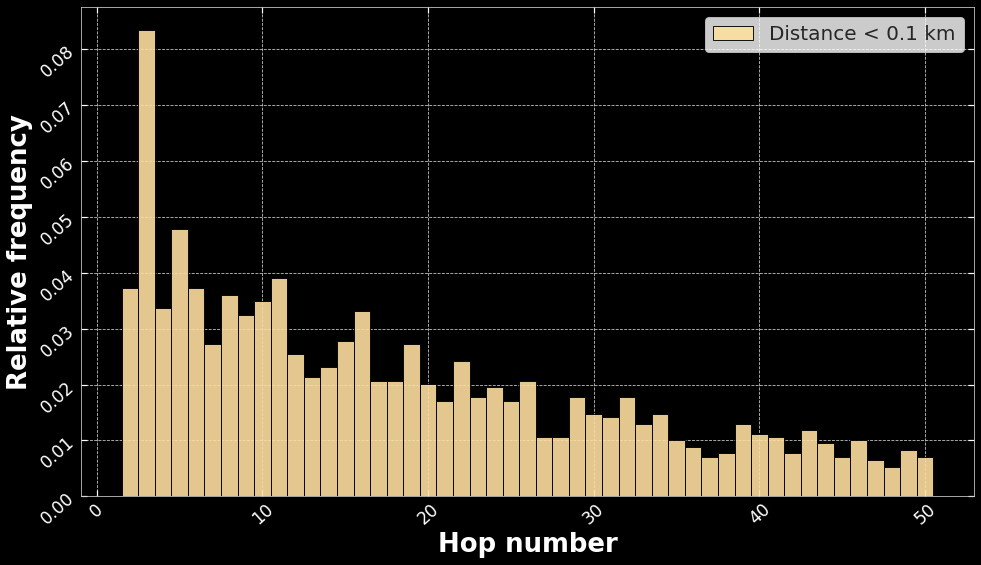

In [123]:
plot_hop_count(req_hop_nrs_100,
               color=cm.magma(0.93),
               THRES=0.1, nr_pairs=nr_pairs)

#### Dist. threshold : $1$ km

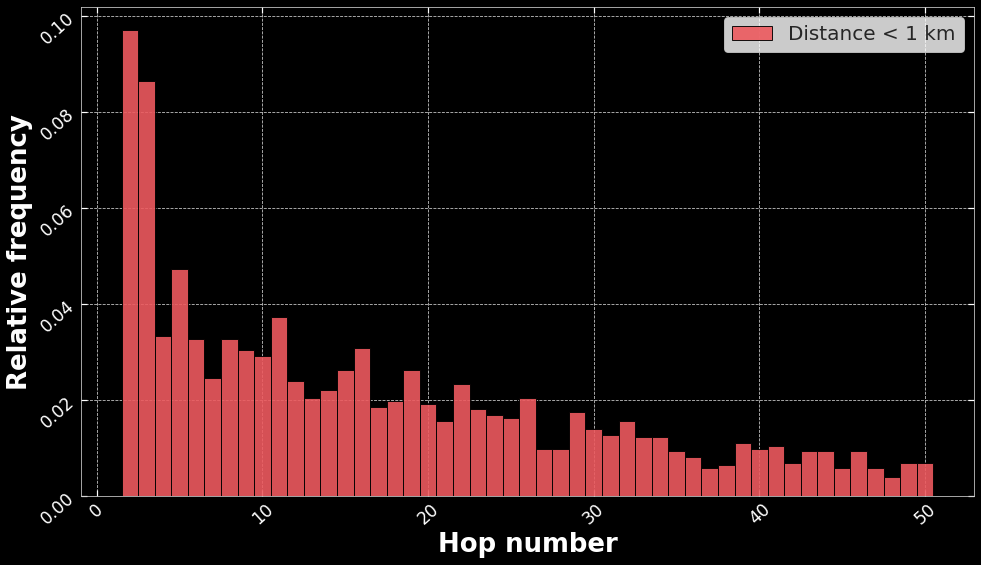

In [124]:
plot_hop_count(req_hop_nrs_1000,
               color=cm.magma(0.65),
               THRES=1, nr_pairs=nr_pairs)

#### Dist. threshold : $10$ km

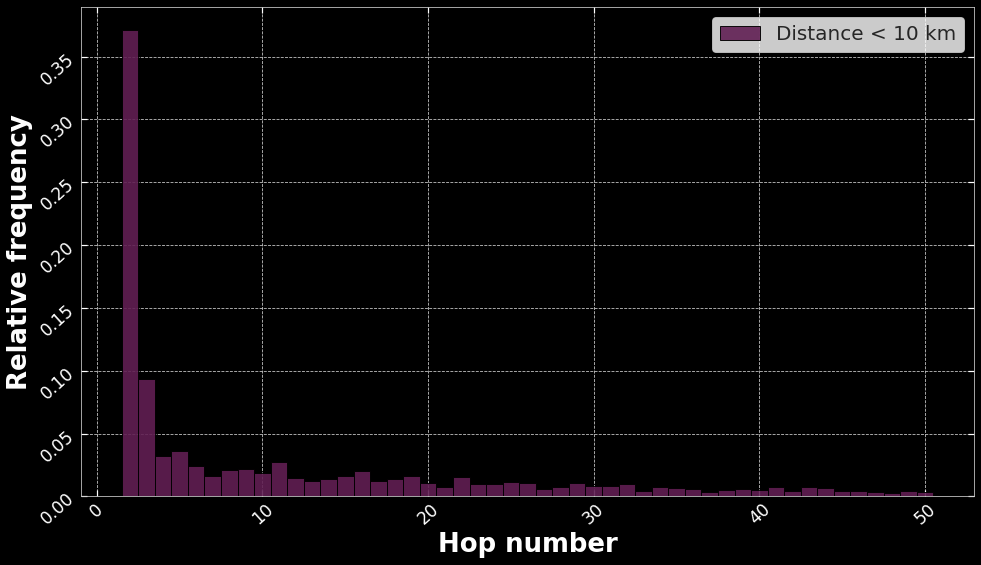

In [125]:
plot_hop_count(req_hop_nrs_10000,
               color=rocket_cmap(0.25),
               THRES=10, nr_pairs=nr_pairs)

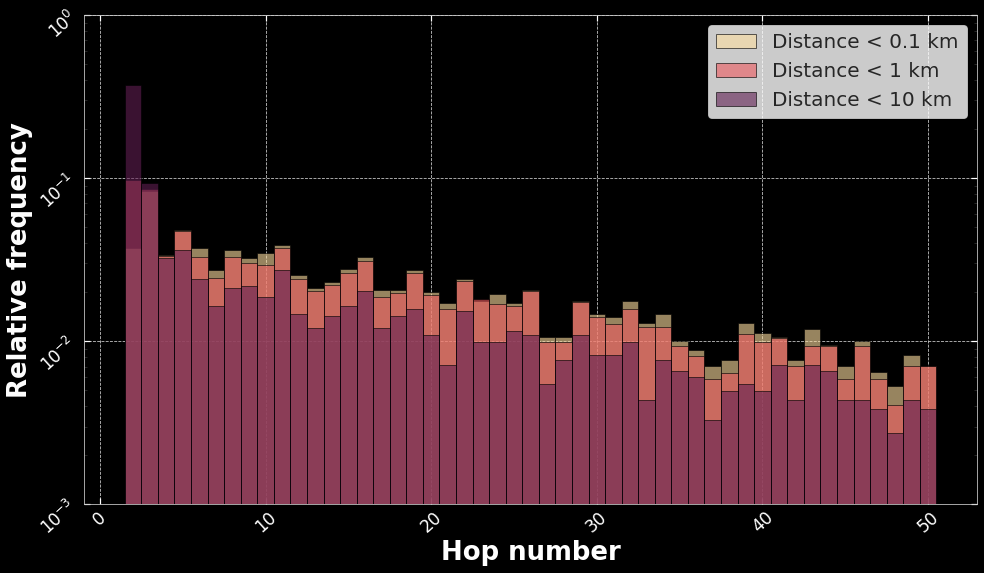

In [136]:
# Plot barplot of hop counts
fig, axes = plt.subplots(figsize=(16,9),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
axes.set_yscale('log')
axes.set_ylim(1e-3, 1)

reqs = [
    req_hop_nrs_100,
    req_hop_nrs_1000,
    req_hop_nrs_10000,
]
colors = [
    cm.magma(0.93),
    cm.magma(0.65),
    rocket_cmap(0.25)
]
thresholds = [
    0.1,
    1,
    10
]
for i, req in enumerate(reqs):
    x = np.array(list(req.keys()))
    y = np.array(list(req.values()))
    axes.bar(x, y/y.sum(), width=1.0, label='Distance < {0} km'.format(thresholds[i]),
             color=colors[i], ec='black', alpha=0.6)

axes.set_xlabel('Hop number', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('Relative frequency', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, labelrotation=42, colors='white')

axes.legend(loc='upper right', fontsize=axislegendsize)

plt.savefig(path_pic + 'success_plot_distance_{0}_pairs.png'.format(nr_pairs),
            dpi = 200,
            bbox_inches='tight')

Text(0.5, 1.0, 'Distance between the target node and the end of path')

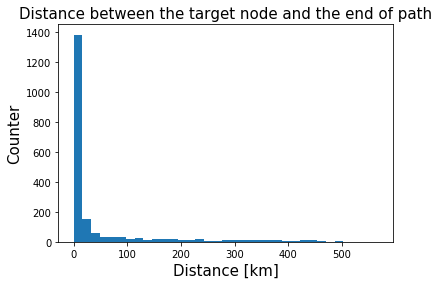

In [32]:
distances_end = list(df_greedy_results_dist.distance_at_end)
# sn.distplot(distances_end,bins=20,norm_hist=False)
plt.hist(distances_end,bins=35)
plt.xlabel('Distance [km]',fontsize = 15)
plt.ylabel('Counter',fontsize=15)
plt.title('Distance between the target node and the end of path',fontsize = 15)
# plt.savefig(path_pic+'distance_at_end_plot_2000_pairs.png',dpi = 200)

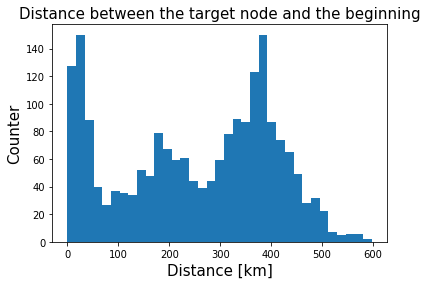

In [174]:
distances_start = list(df_greedy_results_dist.distance_at_start)
# sn.distplot(distances_start,bins=20,norm_hist=False)
plt.hist(distances_start,bins=35)
plt.ylabel('Counter',fontsize=15)
plt.xlabel('Distance [km]',fontsize = 15)
plt.title('Distance between the target node and the beginning',fontsize = 15)
# plt.savefig(path_pic+'distance_at_start_plot_2000_pairs.png',dpi = 200)

## Results and difficulties:
* The algorithm can find a path between the starting and target nodes in general. Or at lest reduce the distance between two users.
* But it has its own **limits**:


* Doesn't reach the target if the path length would be more than the **max hop number**
* **Infinity loops**, in these cases the algorithm breaks and returns with the last closest node
* Hop in a **dead end**.  If the closest neighbor to the target has only degree, there it has no more edges, so we can't get closer to the target, and we can't return the last node. 

## +1. Without distance threshold

### Initialization

In [29]:
nr_pairs = 2000
max_hop = 50
selected_nodes = np.random.choice(df_neigh_list_sub_GC_nodes.source.values, 2*nr_pairs)
starting_points = selected_nodes[:nr_pairs]
target_points = selected_nodes[nr_pairs:]

### Run Greedy algorithm

In [30]:
%%time
# Depends on rig, but takes ~10 minutes
# with NO distance threshold
# THRES : float in [meters]
THRES = None
paths_betw_points_with_dist = paths_between_points(THRES=THRES)

100%|██████████| 2000/2000 [00:13<00:00, 149.48it/s]

CPU times: user 13.2 s, sys: 64.9 ms, total: 13.2 s
Wall time: 13.4 s


In [31]:
save_path_data(starting_points, target_points, paths_betw_points_with_dist,
               THRES='None', nr_pairs=nr_pairs)

In [35]:
df_greedy_results_dist_None = load_path_data(THRES='None', nr_pairs=2000)
df_greedy_results_dist_finished_None = df_greedy_results_dist_None[df_greedy_results_dist_None.path_length < 51]

In [36]:
print('With no distance threshold:')
print_success(df_greedy_results_dist_None,df_greedy_results_dist_finished_None)

With no distance threshold:
The success ratio: 100.00%
2000 successful routing out of 2000



In [38]:
# Calculate path lengths
req_hop_nrs_None = col.Counter(df_greedy_results_dist_finished_None.path_length)

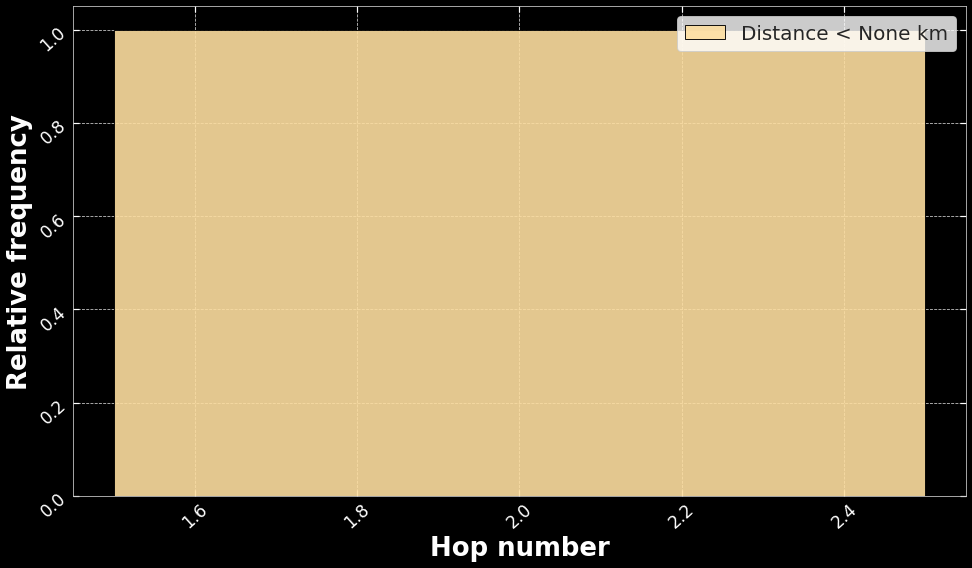

In [39]:
plot_hop_count(req_hop_nrs_None,
               color=cm.magma(0.93),
               THRES='None', nr_pairs=nr_pairs)